# Project 3

In this project, you will perform a logistic regression on the admissions data we've worked with previously in projects 1 and 2

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn import grid_search, cross_validation
from sklearn import linear_model, metrics


%matplotlib inline

In [129]:
df= pd.read_csv("~/ds-sf-44/projects/unit-projects/project-01/datasets/admissions.csv")
print(df.head())

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


In [130]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [131]:
#Fill in missing values
x=df["prestige"].median()
df['prestige']= df['prestige'].fillna(x) 
df['gre'] = df.groupby(["prestige"]).gre.transform(lambda x: x.fillna(x.mean()))
df['gpa'] = df.groupby(["prestige"]).gpa.transform(lambda x: x.fillna(x.mean()))

df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,588.085235,3.390795,2.48500
std,0.466087,115.340107,0.379680,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.390000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [132]:
#Frequency table for prestige and admit rate
total=df.count()
vals, counts=np.unique(df['prestige'], return_counts=True)
results = dict(zip(vals,counts))
print(pd.Series(results))

pd.crosstab(df['prestige'], df['admit'], rownames=["prestige"], colnames=["admit"])

1.0     61
2.0    151
3.0    121
4.0     67
dtype: int64


admit,0,1
prestige,,
1.0,28,33
2.0,97,54
3.0,93,28
4.0,55,12


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [133]:
prestigeV=pd.get_dummies(df.prestige)
prestigeV.columns=['prestige_' + str(i) for i in prestigeV.columns]
df2=df.join(prestigeV)
print(df2.head())


   admit    gre   gpa  prestige  prestige_1.0  prestige_2.0  prestige_3.0  \
0      0  380.0  3.61       3.0             0             0             1   
1      1  660.0  3.67       3.0             0             0             1   
2      1  800.0  4.00       1.0             1             0             0   
3      1  640.0  3.19       4.0             0             0             0   
4      0  520.0  2.93       4.0             0             0             0   

   prestige_4.0  
0             0  
1             0  
2             0  
3             1  
4             1  


#### 2.2 When modeling our class variables, how many do we need? 



Answer: N-1, in this case, we only need three

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios

In [134]:
cols_to_keep = ['admit', 'gre', 'gpa','prestige_1.0','prestige_2.0','prestige_4.0']
handCalc=df2[cols_to_keep]
print(handCalc.head())

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_4.0
0      0  380.0  3.61             0             0             0
1      1  660.0  3.67             0             0             0
2      1  800.0  4.00             1             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


In [135]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
PT1=pd.crosstab(handCalc['prestige_1.0'], handCalc['admit'], rownames=["prestige"], colnames=["admit"])
print(PT1)

admit       0   1
prestige         
0         245  94
1          28  33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [136]:
odds1=PT1[1][1]/PT1[0][1]
print(odds1)

1.1785714285714286


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [137]:
odds2=PT1[1][0]/PT1[0][0]
print(odds2)

0.3836734693877551


#### 3.3 Calculate the odds ratio

In [138]:
OR1=odds1/odds2
print(OR1)

3.071808510638298


#### 3.4 Write this finding in a sentence

Answer: The odds to get to be accepted is 3 times higher if you attended a #1 ranked college

#### 3.5 Print the cross tab for prestige_4

In [139]:
PT4=pd.crosstab(handCalc['prestige_4.0'], handCalc['admit'], rownames=["prestige"], colnames=["admit"])
print(PT4)

admit       0    1
prestige          
0         218  115
1          55   12


#### 3.6 Calculate the OR 

In [140]:
odds1=PT4[1][1]/PT4[0][1]
odds2=PT4[1][0]/PT4[0][0]
OR4=odds1/odds2
print(OR4)

0.41359683794466406


#### 3.7 Write this finding in a sentence

Answer: If you attended a #4 ranked college, than your odds to get to be accepted is only 40% of the chances than the other applicants

## Part 4. Analysis

In [141]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(prestigeV.ix[:, 'prestige_2':])
print(data.head())

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [142]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [143]:
trans_cols=data.columns[1:]
print(trans_cols)

Index(['gre', 'gpa', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0',
       'intercept'],
      dtype='object')


#### 4.2 Fit the model

In [144]:
y=data['admit']
X=data[train_cols]

logit=sm.Logit(y,X)

In [145]:
lm = LogisticRegression()
y=data['admit']
X=data[train_cols]

lm.fit(X, y)
print(lm.coef_)
print(lm.intercept_)
print(df.admit.mean())

[[ 0.0019041   0.30987191 -0.65172972 -1.18984515 -1.40935436 -1.0644588 ]]
[-1.0644588]
0.3175


#### 4.3 Print the summary results

Optimization terminated successfully.
         Current function value: 0.573808
         Iterations 6
                        Results: Logit
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: admit            Pseudo R-squared: 0.082   
Date:               2018-04-21 17:40 AIC:              471.0460
No. Observations:   400              BIC:              494.9948
Df Model:           5                Log-Likelihood:   -229.52 
Df Residuals:       394              LL-Null:          -249.99 
Converged:          1.0000           Scale:            1.0000  
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
gre              0.0022   0.0011  2.0552 0.0399  0.0001  0.0044
gpa              0.7892   0.3318  2.3788 0.0174  0.1390  1.4395
prestige_2.0    -0.6798   0.3162 -2.1497 0.0316 -1.2996 -0.0600
prestige_3.0    -1.3392   0

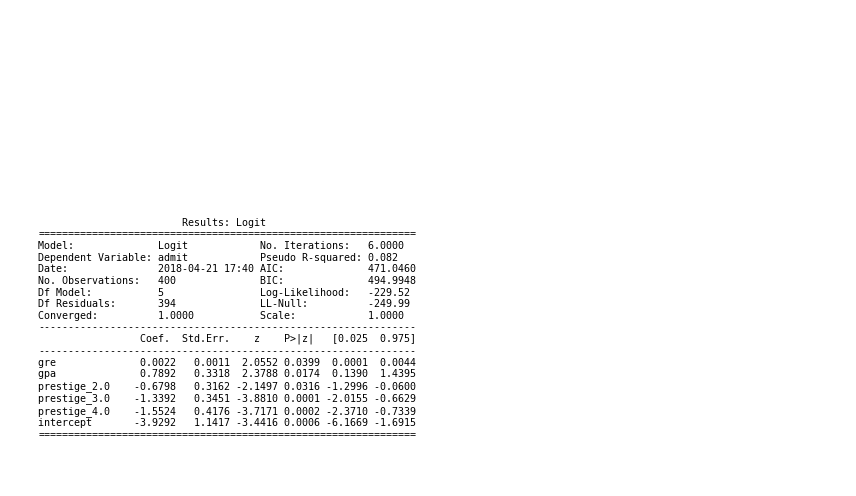

In [146]:
result=logit.fit()
print(result.summary2())
data['proba'] = result.predict(data[trans_cols])

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(result.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png',figsize=(25, 25))

#### 4.4 Calculate the odds ratios of the coefficients and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [147]:
p=result.params
#conf['OR']=result.params
np.exp(p)

gre             1.002251
gpa             2.201716
prestige_2.0    0.506717
prestige_3.0    0.262058
prestige_4.0    0.211730
intercept       0.019659
dtype: float64

In [148]:
conf=result.conf_int()
print(np.exp(conf))

                     0         1
gre           1.000104  1.004402
gpa           1.149074  4.218660
prestige_2.0  0.272639  0.941764
prestige_3.0  0.133253  0.515369
prestige_4.0  0.093386  0.480044
intercept     0.002098  0.184236


#### 4.5 Interpret the OR of Prestige_2

Answer: The odds of getting accepted if you are not from rank #2 colleges will reduce about 50%

#### 4.6 Interpret the OR of GPA

Answer: 1 point higher in GPA score can increase the odds of acceptance by 120%

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified minimum and maximum value--in our case just the min/max observed values.

In [166]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size,1):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out


In [167]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print(gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print(gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.0]]))


[220.         284.44444444 348.88888889 413.33333333 477.77777778
 542.22222222 606.66666667 671.11111111 735.55555556 800.        ]
[2.26       2.45333333 2.64666667 2.84       3.03333333 3.22666667
 3.42       3.61333333 3.80666667 4.        ]


#### 5.1 Re-create the dummy variables

In [168]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']
# keep only what we need for making predictions
data_temp=combos.join(dummy_ranks)
cols_to_keep = ['gre','gpa','prestige_2.0','prestige_3.0', 'prestige_4.0','intercept']
data_keep=data_temp[cols_to_keep]
print(data_keep.tail())

       gre       gpa  prestige_2.0  prestige_3.0  prestige_4.0  intercept
395  800.0  3.806667             0             0             1        1.0
396  800.0  4.000000             0             0             0        1.0
397  800.0  4.000000             1             0             0        1.0
398  800.0  4.000000             0             1             0        1.0
399  800.0  4.000000             0             0             1        1.0


#### 5.2 Make predictions on the enumerated dataset

In [169]:
data_keep['proba'] = result.predict(data_keep)
print(data_keep.tail())

       gre       gpa  prestige_2.0  prestige_3.0  prestige_4.0  intercept  \
395  800.0  3.806667             0             0             1        1.0   
396  800.0  4.000000             0             0             0        1.0   
397  800.0  4.000000             1             0             0        1.0   
398  800.0  4.000000             0             1             0        1.0   
399  800.0  4.000000             0             0             1        1.0   

        proba  
395  0.336574  
396  0.736224  
397  0.585800  
398  0.422442  
399  0.371447  


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### 5.3 Interpret findings for the last 4 observations

Answer: Last four candidates all have perfect score in GRE and GPA, they are just attending different types of college. The probability of getting accepted are from almost 74% to 58%, to 42% to 37%. So it's definitely highly correlated with the "prestige" of current colledge. Better the school is higher the odds to be accepted.

## Bonus:

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score

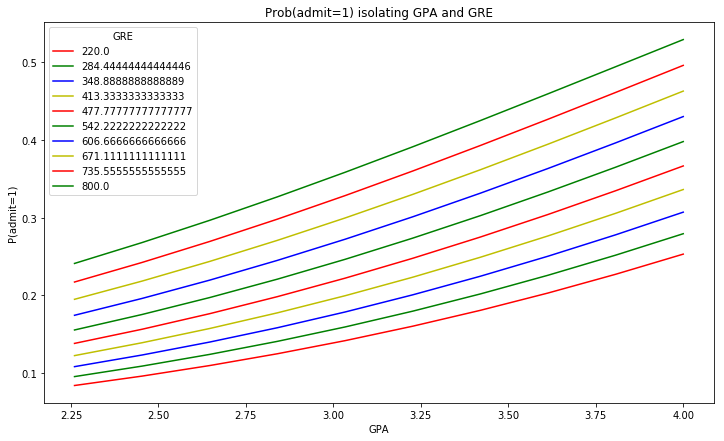

In [171]:
# This is Using The Linearly Space Data
grouped = pd.pivot_table(data_keep, values=['proba'], index=['gpa', 'gre'],
                            aggfunc=np.mean)

 
colors =['r','g','b','y','r','g','b','y','r','g','b','y']
i=0
for col in data_keep.gre.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    pl.plot(plt_data.index.get_level_values(0), plt_data['proba'],
            color=colors[i])
    i=i+1
pl.xlabel("GPA")
pl.ylabel("P(admit=1)")
pl.legend(data_keep.gre.unique(),loc='upper left', title='GRE')
pl.title("Prob(admit=1) isolating GPA and GRE")
pl.savefig('GPAvsGRE_orig.png')

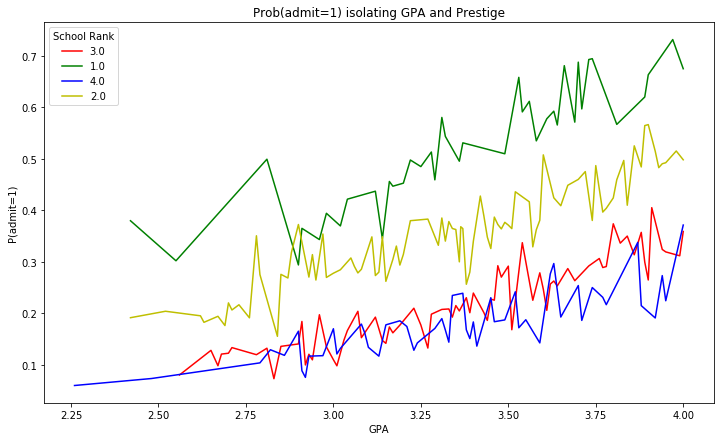

In [160]:
# This chart is to show GPA and Prestige relationship with admission, and using original data
data2=data.join(df['prestige'])
grouped = pd.pivot_table(data2, values=['proba'], index=['gpa', 'prestige'],
                            aggfunc=np.mean) 
colors =['r','g','b','y']
i=0
for col in data2.prestige.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    pl.plot(plt_data.index.get_level_values(0), plt_data['proba'],
            color=colors[i])
    i=i+1
pl.xlabel("GPA")
pl.ylabel("P(admit=1)")
pl.legend(data2.prestige.unique(),loc='upper left', title='School Rank')
pl.title("Prob(admit=1) isolating GPA and Prestige")
pl.savefig('GPAvsPrestige.png')

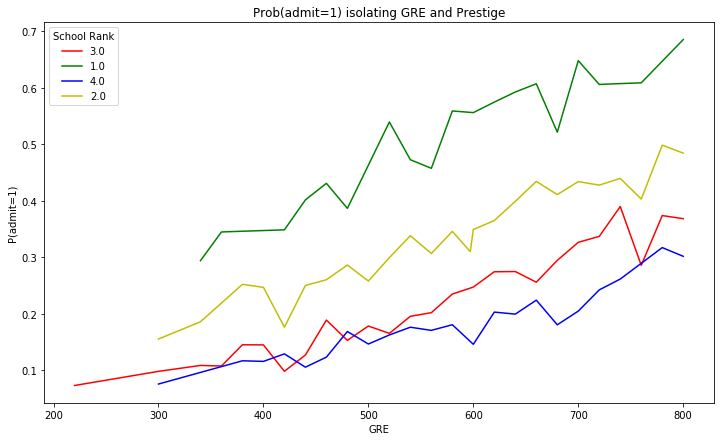

In [172]:
# This chart is to show GRE and Prestige relationship with admission, and using original data
grouped = pd.pivot_table(data2, values=['proba'], index=['gre', 'prestige'],
                            aggfunc=np.mean) 
colors =['r','g','b','y']
i=0
for col in data2.prestige.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    pl.plot(plt_data.index.get_level_values(0), plt_data['proba'],
            color=colors[i])
    i=i+1
pl.xlabel("GRE")
pl.ylabel("P(admit=1)")
pl.legend(data2.prestige.unique(),loc='upper left', title='School Rank')
pl.title("Prob(admit=1) isolating GRE and Prestige")
pl.savefig('GPAvsPrestige.png')

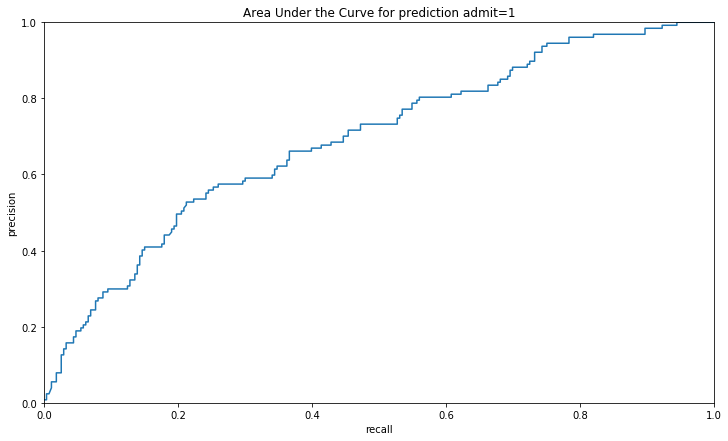

In [163]:
ax = plt.subplot(111)
vals = metrics.roc_curve(data.admit, data.proba)
ax.plot(vals[0], vals[1])

ax.set(title='Area Under the Curve for prediction admit=1', 
       xlabel='recall', ylabel='precision', xlim=(0, 1), ylim=(0, 1))
plt.savefig('ROC.png')

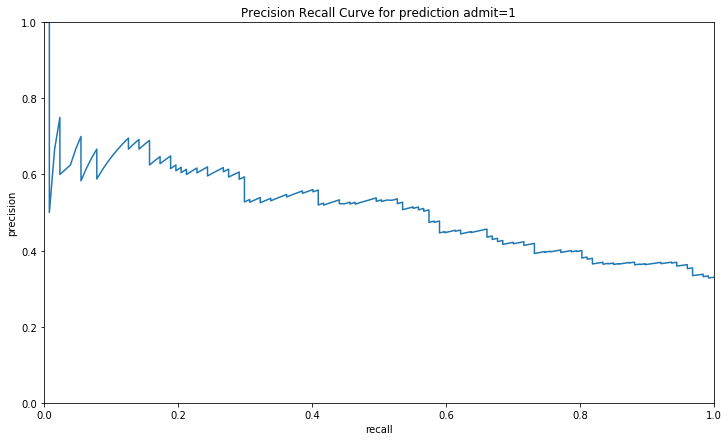

In [164]:
ax = plt.subplot(111)
vals = metrics.precision_recall_curve(data.admit, data.proba)
ax.plot(vals[1], vals[0])


ax.set(title='Precision Recall Curve for prediction admit=1', 
       xlabel='recall', ylabel='precision', xlim=(0, 1), ylim=(0, 1))

plt.savefig('PrecisionRecall.png')